<img src="../images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png" align="left"></img>

# wradlib Phase Processing - System PhiDP - ZPHI-Method

---

## Overview

Within this notebook, we will cover:

1. Reading sweep data into xarray based Dataset
1. Retrieval of system PhiDP
1. ZPHI Phase processing
1. Attenuation correction using specific Attenuation

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Projections |

- **Time to learn**: 10 minutes

In [1]:
import datetime as dt
import glob
import os
import sys
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.integrate import cumulative_trapezoid

import wradlib as wrl
import xradar as xd

## Import data

As a quick example to show the algorithm, we use a file from Down Under. For the further processing we use x-band data from BoXPol research radar at the University of Bonn, Germany.

In [2]:
boxpol = "data/hdf5/boxpol/2014-11-16--03_45_00,00.mvol"
terrey = "data/hdf5/terrey_39.h5"

In [3]:
swp0 = xr.open_dataset(terrey, engine="odim")
swp0 = swp0.pipe(wrl.georef.georeference_dataset).compute()

(we use .compute() here to load the data out of a dask array, otherwise some functions below will complain)

## Pre-Processing

System PHIDP aka Phase Offset

The following function returns phase offset as well as start and stop ranges of the region of interest (first precipitating bins).

In [4]:
def phase_offset(phioff, method=None, rng=3000.0, npix=None, **kwargs):
    """Calculate Phase offset.

    Parameter
    ---------
    phioff : xarray.DataArray
        differential phase DataArray

    Keyword Arguments
    -----------------
    method : str
        aggregation method, defaults to 'median'
    rng : float
        range in m to calculate system phase offset

    Return
    ------
    phidp_offset : xarray.Dataset
        Dataset with PhiDP offset and start/stop ranges
    """
    range_step = np.diff(phioff.range)[0]
    nprec = int(rng / range_step)
    if not nprec % 2:
        nprec += 1

    if npix is None:
        npix = nprec // 2 + 1

    # create binary array
    phib = xr.where(np.isnan(phioff), 0, 1)

    # take nprec range bins and calculate sum
    phib_sum = phib.rolling(range=nprec, **kwargs).sum(skipna=True)

    # find at least N pixels in
    # phib_sum_N = phib_sum.where(phib_sum >= npix)
    phib_sum_N = xr.where(phib_sum <= npix, phib_sum, npix)

    # get start range of first N consecutive precip bins
    start_range = (
        phib_sum_N.idxmax(dim="range") - nprec // 2 * np.diff(phib_sum.range)[0]
    )
    start_range = xr.where(start_range < 0, 0, start_range)

    # get stop range
    stop_range = start_range + rng
    # get phase values in specified range
    off = phioff.where(
        (phioff.range >= start_range) & (phioff.range <= stop_range), drop=False
    )
    # calculate nan median over range
    if method is None:
        method = "median"
    func = getattr(off, method)
    off_func = func(dim="range", skipna=True)

    return xr.Dataset(
        dict(
            PHIDP_OFFSET=off_func,
            start_range=start_range,
            stop_range=stop_range,
            phib_sum=phib_sum,
            phib=phib,
        )
    )

## Example Showcase 

In [5]:
dr_m = swp0.range.diff("range").median()
swp_msk = swp0.where((swp0.DBZH >= 0.0))
swp_msk = swp_msk.where(swp_msk.RHOHV > 0.8)
swp_msk = swp_msk.where(swp_msk.range > dr_m * 5)

phi_masked = swp_msk.PHIDP.copy()
off = phase_offset(
    phi_masked, method="median", rng=2000.0, npix=7, center=True, min_periods=4
)
phioff = off.PHIDP_OFFSET.median(dim="azimuth", skipna=True)

(50.0, 150.0)

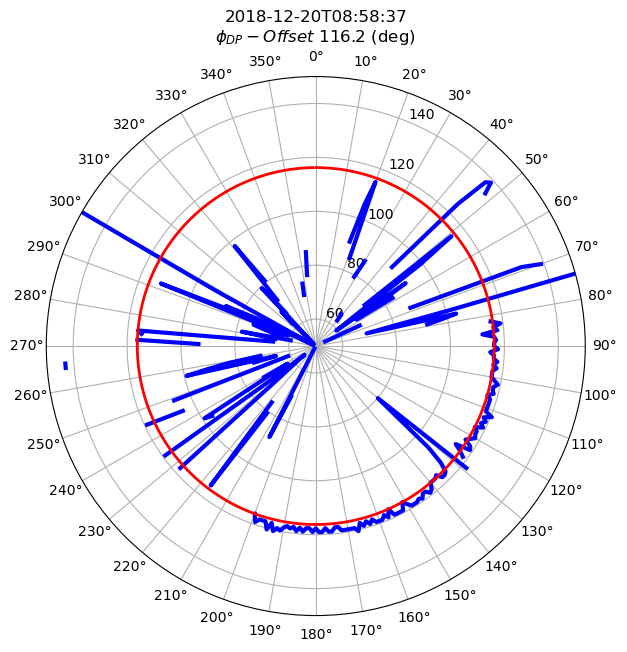

In [6]:
fig = plt.figure(figsize=(16, 7))
ax1 = plt.subplot(111, projection="polar")
# set the lable go clockwise and start from the top
ax1.set_theta_zero_location("N")
# clockwise
ax1.set_theta_direction(-1)
theta = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
ax1.plot(theta, off.PHIDP_OFFSET, color="b", linewidth=3)

ax1.plot(theta, np.ones_like(theta) * phioff.values, color="r", lw=2)
ti = off.time.values.astype("M8[s]")[0]
om = phioff.values
tx = ax1.set_title(f"{ti}\n" + r"$\phi_{DP}-Offset$ " + f"{om:.1f} (deg)")
tx.set_y(1.1)
xticks = ax1.set_xticks(np.pi / 180.0 * np.linspace(0, 360, 36, endpoint=False))
ax1.set_ylim(50, 150)

(0.0, 25000.0)

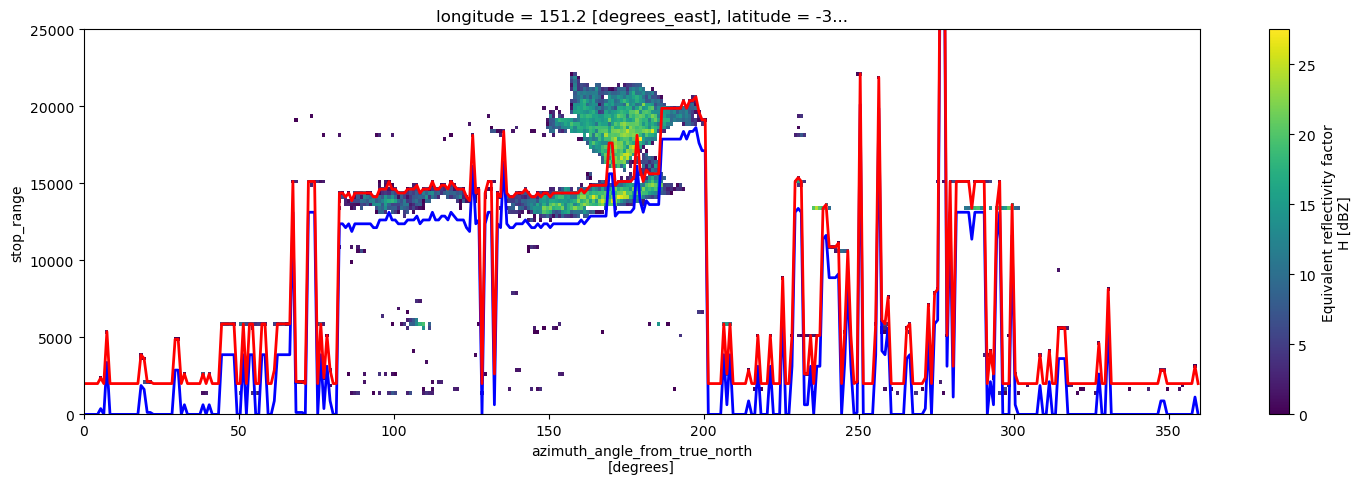

In [7]:
fig = plt.figure(figsize=(18, 5))
swp_msk.DBZH.plot(x="azimuth")
off.start_range.plot(c="b", lw=2)
off.stop_range.plot(c="r", lw=2)
plt.gca().set_ylim(0, 25000)

## Process BoXPol data


In [8]:
swp = xr.open_dataset(boxpol, engine="gamic")
swp = swp.pipe(wrl.georef.georeference_dataset)

In [9]:
swp

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1000)
Coordinates: (12/13)
  * azimuth            (azimuth) float64 0.5301 1.53 2.516 ... 357.5 358.5 359.5
    elevation          (azimuth) float64 1.505 1.505 1.505 ... 1.505 1.505 1.505
    time               (azimuth) datetime64[ns] ...
  * range              (range) float32 50.0 150.0 250.0 ... 9.985e+04 9.995e+04
    longitude          float64 7.072
    latitude           float64 50.73
    ...                 ...
    x                  (azimuth, range) float64 0.4624 1.387 ... -856.2 -857.0
    y                  (azimuth, range) float64 49.98 149.9 ... 9.988e+04
    z                  (azimuth, range) float64 100.9 103.5 ... 3.313e+03
    gr                 (azimuth, range) float64 49.98 149.9 ... 9.988e+04
    rays               (azimuth, range) float64 0.5301 0.5301 ... 359.5 359.5
    bins               (azimuth, range) float32 50.0 150.0 ... 9.995e+04
Data variables: (12/17)
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    DBZV               (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    DBTH               (azimuth, range) float32 ...
    ...                 ...
    ZDR                (azimuth, range) float32 ...
    sweep_mode         <U20 'azimuth_surveillance'
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 ...

In [10]:
vol = wrl.io.open_gamic_dataset(boxpol)

/home/jgiles/mambaforge/envs/wradlib4/lib/python3.11/site-packages/wradlib/io/hdf.py:139: FutureWarning: `open_gamic_dataset` functionality has been moved to `xradar`-package and will be removed in 2.0. Use `open_gamic_datatree` from `xradar`-package.
  return open_radar_dataset(filename_or_obj, engine=GamicBackendEntrypoint, **kwargs)


In [11]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 1)
Elevation(s): (1.5)

In [12]:
swp = vol[0].copy()
swp = swp.pipe(wrl.georef.georeference_dataset)

In [13]:
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1000)
Coordinates: (12/15)
  * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * range              (range) float32 50.0 150.0 250.0 ... 9.985e+04 9.995e+04
    elevation          (azimuth) float64 1.505 1.505 1.505 ... 1.505 1.505 1.505
    rtime              (azimuth) datetime64[ns] ...
    sweep_mode         <U20 'azimuth_surveillance'
    longitude          float64 7.072
    ...                 ...
    x                  (azimuth, range) float64 0.4362 1.309 ... -870.7 -871.6
    y                  (azimuth, range) float64 49.98 149.9 ... 9.988e+04
    z                  (azimuth, range) float64 100.9 103.5 ... 3.313e+03
    gr                 (azimuth, range) float64 49.98 149.9 ... 9.988e+04
    rays               (azimuth, range) float64 0.5 0.5 0.5 ... 359.5 359.5
    bins               (azimuth, range) float32 50.0 150.0 ... 9.995e+04
Data variables: (12/16)
    KDP                (azimuth, range) float32 ...
    PHIDP              (azimuth, range) float32 ...
    DBZH               (azimuth, range) float32 ...
    DBZV               (azimuth, range) float32 ...
    RHOHV              (azimuth, range) float32 ...
    DBTH               (azimuth, range) float32 ...
    ...                 ...
    WRADV              (azimuth, range) float32 ...
    ZDR                (azimuth, range) float32 ...
    sweep_number       int64 ...
    prt_mode           <U7 ...
    follow_mode        <U7 ...
    sweep_fixed_angle  float64 1.5
Attributes:
    fixed_angle:  1.5

### Create Plot

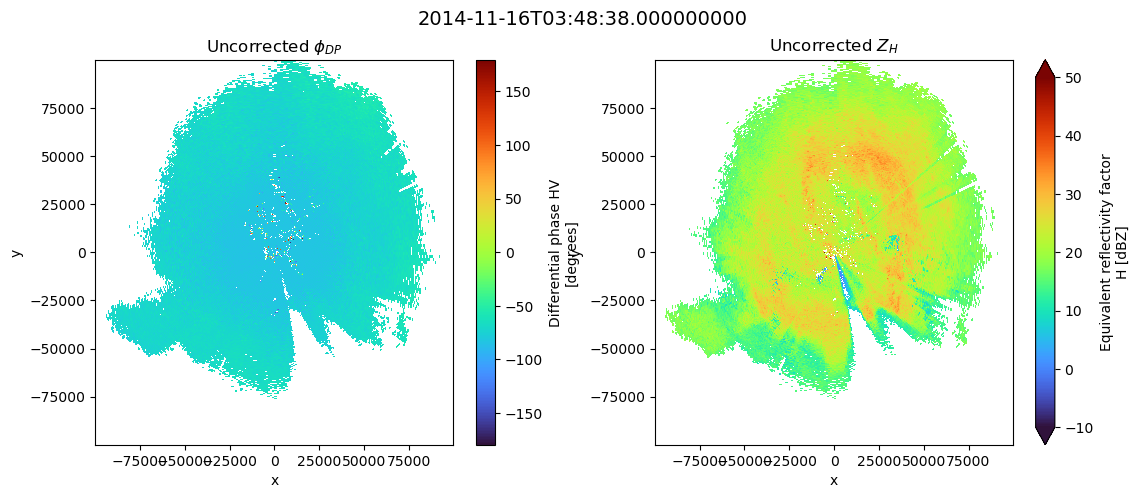

In [15]:
fig = plt.figure(figsize=(13, 5))

ax1 = fig.add_subplot(121)
im1 = swp.PHIDP.where(swp.RHOHV > 0.8).plot(x="x", y="y", ax=ax1, cmap="turbo")
t = plt.title(r"Uncorrected $\phi_{DP}$")
t.set_y(1.1)

ax2 = fig.add_subplot(122)
im2 = swp.DBZH.where(swp.RHOHV > 0.8).plot(
    x="x", y="y", ax=ax2, cmap="turbo", vmin=-10, vmax=50
)
t = plt.title(r"Uncorrected $Z_{H}$")
t.set_y(1.1)
fig.suptitle(swp.time.values, fontsize=14)
fig.subplots_adjust(wspace=0.25)

### Apply reasonable masking

In [16]:
dr_m = swp.range.diff("range").median()
swp_msk = swp.where((swp.DBZH >= 0.0))
swp_msk = swp_msk.where(swp_msk.RHOHV > 0.8)
swp_msk = swp_msk.where(swp_msk.range > dr_m * 2)


phi_masked = swp_msk.PHIDP.copy()
off = phase_offset(
    phi_masked, method="median", rng=2000.0, npix=7, center=True, min_periods=2
)
phioff = off.PHIDP_OFFSET.median(dim="azimuth", skipna=True)

### Plot phase offset distribution

(-120.0, -70.0)

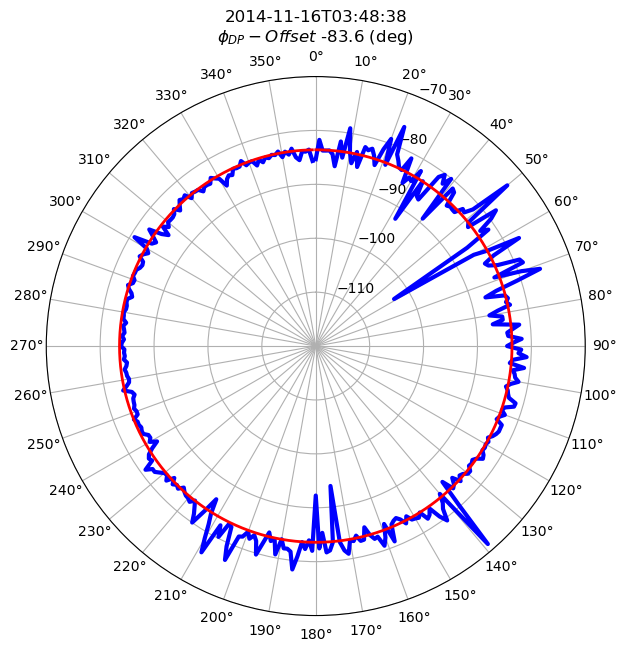

In [18]:
fig = plt.figure(figsize=(16, 7))
ax1 = plt.subplot(111, projection="polar")
# set the lable go clockwise and start from the top
ax1.set_theta_zero_location("N")
# clockwise
ax1.set_theta_direction(-1)
theta = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
ax1.plot(theta, off.PHIDP_OFFSET, color="b", linewidth=3)

ax1.plot(theta, np.ones_like(theta) * phioff.values, color="r", lw=2)
ti = off.time.values.astype("M8[s]")
om = phioff.values
tx = ax1.set_title(f"{ti}\n" + r"$\phi_{DP}-Offset$ " + f"{om:.1f} (deg)")
tx.set_y(1.1)
xticks = ax1.set_xticks(np.pi / 180.0 * np.linspace(0, 360, 36, endpoint=False))
ax1.set_ylim(-120, -70)

(0.0, 10000.0)

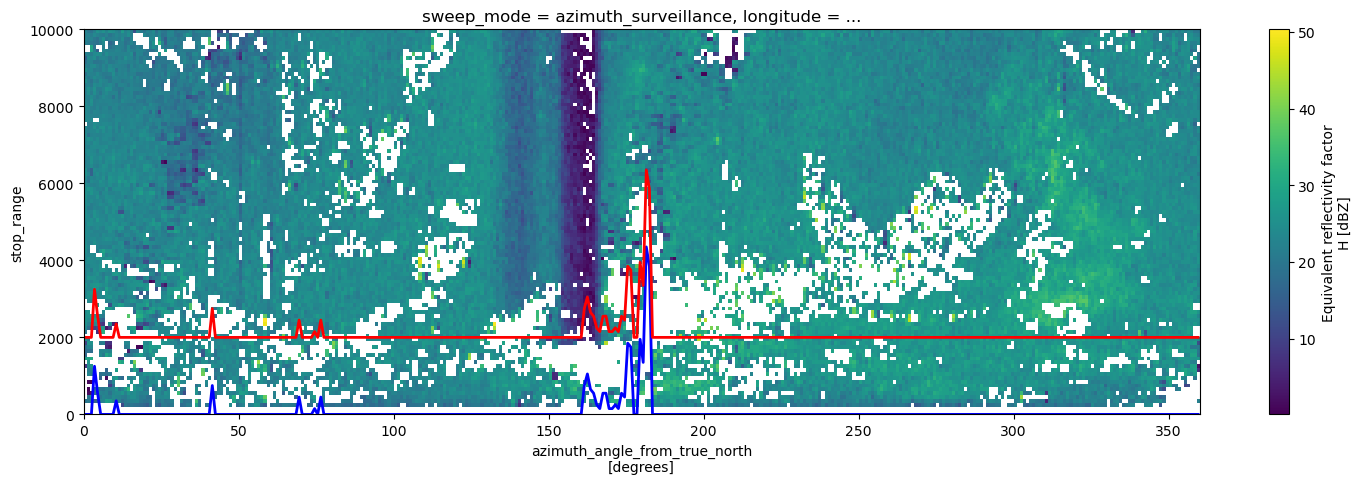

In [19]:
fig = plt.figure(figsize=(18, 5))
swp_msk.DBZH.plot(x="azimuth")
off.start_range.plot(c="b", lw=2)
off.stop_range.plot(c="r", lw=2)
plt.gca().set_ylim(0, 10000)

Pleaser refer to the [ZPHI-Method](#ZPHI-Method) section at the bottom of this notebook for references and equations.

### Retrieving $\Delta \phi_{DP}$

We will use the simple method of finding the first and the last non NAN values per ray from $\phi_{DP}^{corr}$.

This is the most simple and probably not very robust method.

In [20]:
def phase_zphi(phi, rng=1000.0, **kwargs):
    range_step = np.diff(phi.range)[0]

    nprec = int(rng / range_step)

    if nprec % 2:
        nprec += 1

    # create binary array
    phib = xr.where(np.isnan(phi), 0, 1)

    # take nprec range bins and calculate sum
    phib_sum = phib.rolling(range=nprec, **kwargs).sum(skipna=True)

    offset = nprec // 2 * np.diff(phib_sum.range)[0]
    offset_idx = nprec // 2

    start_range = phib_sum.idxmax(dim="range") - offset
    start_range_idx = phib_sum.argmax(dim="range") - offset_idx

    stop_range = phib_sum[:, ::-1].idxmax(dim="range") - offset
    stop_range_idx = (
        len(phib_sum.range) - (phib_sum[:, ::-1].argmax(dim="range") - offset_idx) - 2
    )

    # get phase values in specified range
    first = phi.where(
        (phi.range >= start_range) & (phi.range <= start_range + rng), drop=True
    ).quantile(0.15, dim="range", skipna=True)
    last = phi.where(
        (phi.range >= stop_range - rng) & (phi.range <= stop_range), drop=True
    ).quantile(0.95, dim="range", skipna=True)

    return xr.Dataset(
        dict(
            phib=phib_sum,
            offset=offset,
            offset_idx=offset_idx,
            start_range=start_range,
            stop_range=stop_range,
            first=first.drop("quantile"),
            first_idx=start_range_idx,
            last=last.drop("quantile"),
            last_idx=stop_range_idx,
        )
    )

Apply extraction of phase parameters.

In [21]:
cphase = phase_zphi(swp_msk.PHIDP, rng=2000.0, center=True, min_periods=7)

Apply azimuthal averaging.

In [22]:
cphase = (
    cphase.pad(pad_width={"azimuth": 2}, mode="wrap")
    .rolling(azimuth=5, center=True)
    .median(skipna=True)
    .isel(azimuth=slice(2, -2))
)

### $\Delta \phi_{DP}$ - Polar Plots

This visualizes `first` and `last` indizes including $\Delta \phi_{DP}$.

In [23]:
dphi = cphase.last - cphase.first
dphi = dphi.where(dphi >= 0).fillna(0)

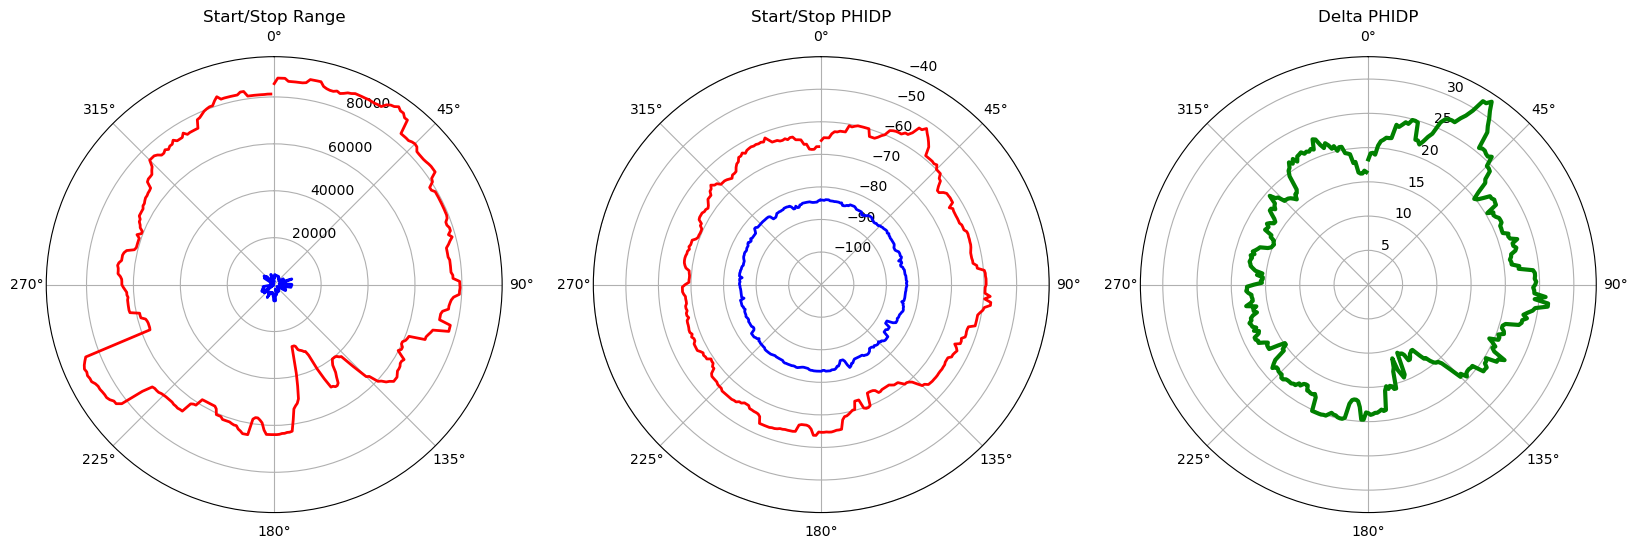

In [24]:
fig = plt.figure(figsize=(20, 9))
ax1 = plt.subplot(131, projection="polar")
ax2 = plt.subplot(132, projection="polar")
ax3 = plt.subplot(133, projection="polar")
# set the lable go clockwise and start from the top
ax1.set_theta_zero_location("N")
ax2.set_theta_zero_location("N")
ax3.set_theta_zero_location("N")
# clockwise
ax1.set_theta_direction(-1)
ax2.set_theta_direction(-1)
ax3.set_theta_direction(-1)
theta = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
ax1.plot(theta, cphase.start_range, color="b", linewidth=2)
ax1.plot(theta, cphase.stop_range, color="r", linewidth=2)
_ = ax1.set_title("Start/Stop Range")

ax2.plot(theta, cphase.first, color="b", linewidth=2)
ax2.plot(theta, cphase.last, color="r", linewidth=2)
_ = ax2.set_title("Start/Stop PHIDP")
ax2.set_ylim(-110, -40)

ax3.plot(theta, dphi, color="g", linewidth=3)
# ax3.plot(theta, dphi_old, color="k", linewidth=1)
_ = ax3.set_title("Delta PHIDP")

### Calculating $f\Delta\phi_{DP}$

$$f\Delta\phi_{DP} = 10^{0.1 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}} - 1$$

In [25]:
# Coefficients for x-band
alphax = 0.28
betax = 0.05
bx = 0.78
# need to expand alphax to dphi-shape
fdphi = 10 ** (0.1 * bx * alphax * dphi) - 1
fdphi

<xarray.DataArray (azimuth: 360)>
array([1.50772944, 1.621746  , 1.63263211, 1.59938947, 1.77879842,
       1.87674877, 1.91353846, 1.96305219, 1.96305219, 1.97124872,
       2.29083108, 2.25196971, 2.31872025, 2.39724185, 2.37292792,
       2.49336399, 2.49336399, 2.4702802 , 2.05962546, 2.05962546,
       1.98779264, 2.08415043, 2.22085707, 2.33125884, 2.6826384 ,
       2.81518698, 2.85859008, 2.86824995, 2.85859008, 3.03636579,
       3.18973989, 3.43876111, 3.89274439, 3.89274439, 4.04998114,
       3.7410609 , 3.5279313 , 3.29545116, 3.13226527, 2.63714176,
       2.68060436, 2.68060436, 2.63714176, 2.6171011 , 2.68569016,
       2.42366977, 2.41700817, 2.38506371, 2.17667475, 2.11841838,
       1.87436571, 1.71911294, 1.76150461, 1.87436571, 2.01607107,
       2.01607107, 2.04992121, 2.0311066 , 2.01923888, 1.77006176,
       1.88550466, 1.85852905, 1.88630187, 1.93616259, 1.94184574,
       1.94184574, 1.88550356, 1.88494586, 1.87801993, 1.87801993,
       1.98605966, 1.96387083, 1.98770987, 2.13569607, 2.00903912,
       2.00903912, 2.06478535, 2.02759084, 1.92099396, 1.90831172,
       1.87333389, 1.8936456 , 1.8936456 , 2.05362955, 2.0340373 ,
       2.36548218, 2.40602815, 2.40602815, 2.39442893, 2.43024869,
       2.40475917, 2.35513227, 2.38211962, 2.38960217, 2.68670986,
       2.4064985 , 2.76909239, 2.76909239, 2.44544354, 2.39161573,
...
       1.48493842, 1.40258469, 1.35526881, 1.35526881, 1.36570186,
       1.36570186, 1.41723047, 1.45288304, 1.43734691, 1.43734691,
       1.3127157 , 1.18417608, 1.20235217, 1.17394212, 1.17394212,
       1.27155794, 1.1853823 , 1.30506194, 1.35140081, 1.39781004,
       1.4092306 , 1.42928047, 1.41776486, 1.40155549, 1.43562991,
       1.3748696 , 1.41656282, 1.3748696 , 1.3429393 , 1.31783232,
       1.19242757, 1.14515811, 1.13333828, 1.12173051, 1.14116148,
       1.14836012, 1.21945297, 1.22129306, 1.3589155 , 1.34099845,
       1.32938614, 1.38209702, 1.34488177, 1.28477377, 1.27847183,
       1.32231864, 1.39661884, 1.47261211, 1.47261211, 1.40856539,
       1.45742654, 1.4808222 , 1.64794967, 1.53695988, 1.51025952,
       1.38473063, 1.38078131, 1.37093571, 1.34734462, 1.30716441,
       1.26344584, 1.34410378, 1.34734462, 1.39605621, 1.67293704,
       1.77450348, 1.81270428, 1.91514859, 1.84828094, 1.93210992,
       1.83807067, 1.93210992, 1.94916881, 1.97239827, 1.91192921,
       1.93486535, 1.91192921, 1.94949493, 1.91353846, 2.13396412,
       2.1055235 , 1.96059651, 1.86960552, 1.96059651, 1.89748485,
       1.80843354, 1.85056417, 1.74022627, 1.80525399, 1.80215598,
       1.66482719, 1.64868023, 1.62798185, 1.45695102, 1.47261211,
       1.28540588, 1.26341505, 1.26341505, 1.30888565, 1.28414358])
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 1.505 1.505 1.505 1.505 ... 1.505 1.505 1.505
    rtime       (azimuth) datetime64[ns] 2014-11-16T03:48:49 ... 2014-11-16T0...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 7.072
    latitude    float64 50.73
    altitude    float64 99.5
    time        datetime64[ns] 2014-11-16T03:48:38

### Calculating Reflectivity Integrals/Sums

$$za(r) = \left[Z_a(r) \right ]^b$$

$$iza(r,r2) = 0.46 \cdot b \cdot \int_{r}^{r2} \left [Z_a(s) \right ]^b ds$$

We do not restrict (mask) the reflectivities for now, but switch between `DBTH` and `DBZH` to see the difference.

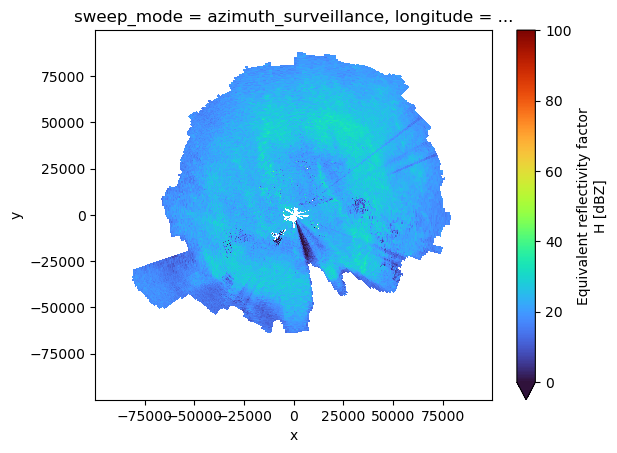

In [26]:
zhraw = swp.DBZH.where(
    (swp.range > cphase.start_range) & (swp.range < cphase.stop_range)
)
zhraw.plot(x="x", y="y", cmap="turbo", vmin=0, vmax=100)

In [27]:
# calculate linear reflectivity and ^b
zax = zhraw.pipe(wrl.trafo.idecibel).fillna(0)
za = zax**bx
# set masked to zero for integration
za_zero = za.fillna(0)

Calculate cumulative integral, and subtract from maximum. That way we have the cumulative sum for every bin until the end of the ray.

In [28]:
def cumulative_trapezoid_xarray(da, dim, initial=0):
    """Intgration with the scipy.integrate.cumtrapz.

    Parameter
    ---------
    da : xarray.DataArray
        array with differential phase data
    dim : int
        size of window in range dimension

    Keyword Arguments
    -----------------
    initial : float
        minimum number of valid bins

    Return
    ------
    kdp : xarray.DataArray
        DataArray with specific differential phase values
    """
    x = da[dim]
    dx = x.diff(dim).median(dim).values
    if x.attrs["units"] == "meters":
        dx /= 1000.0
    return xr.apply_ufunc(
        cumulative_trapezoid,
        da,
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
        dask="parallelized",
        kwargs=dict(axis=da.get_axis_num(dim), initial=initial, dx=dx),
        dask_gufunc_kwargs=dict(allow_rechunk=True),
    )

In [29]:
iza_x = 0.46 * bx * za_zero.pipe(cumulative_trapezoid_xarray, "range", initial=0)
iza = iza_x.max("range") - iza_x

### Calculating Attenuation $A_{H}$ for whole domain

$$A_{H}(r) = \frac{\left [Z_a(r) \right ]^b \cdot f(\Delta \phi_{DP})}{0.46b \int_{r1}^{r2} \left [Z_a(s) \right ]^b ds + f(\Delta \phi_{DP}) \cdot 0.46b \int_{r}^{r2} \left [Z_a(s) \right ]^b ds}$$

We can reduce the number of operations by rearranging the equation like this:

$$A_{H}(r) = \frac{\left [Z_a(r) \right ]^b}{\frac{0.46b \int_{r1}^{r2} \left [Z_a(s) \right ]^b ds}{f(\Delta \phi_{DP})} + 0.46b \int_{r}^{r2} \left [Z_a(s) \right ]^b ds}$$

In [30]:
iza_fdphi = iza / fdphi
idx = cphase.first_idx.astype(int)
iza_first = iza_fdphi[:, idx]
ah = za / (iza_first + iza)

Give it a name!

In [31]:
ah.name = "AH"
ah.attrs["short_name"] = "specific_attenuation_h"
ah.attrs["long_name"] = "Specific attenuation H"
ah.attrs["units"] = "dB/km"

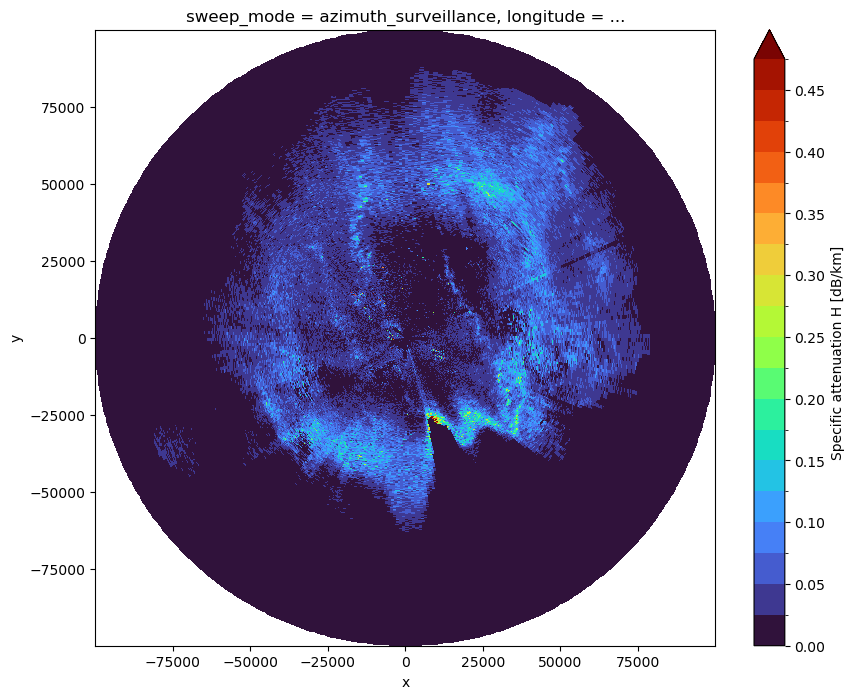

In [32]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ticks_ah = np.arange(0, 5, 0.2)
im = ah.plot(x="x", y="y", ax=ax, cmap="turbo", levels=np.arange(0, 0.5, 0.025))

### Calculate $\phi_{DP}^{cal}(r, \alpha)$ for whole domain

$$\phi_{DP}^{cal}(r_i, \alpha) = 2 \cdot \int_{r1}^{r2} \frac{A_H(s; \alpha)}{\alpha}ds$$

In [33]:
phical = 2 * (ah / alphax).pipe(cumulative_trapezoid_xarray, "range", initial=0)
phical.name = "PHICAL"
phical.attrs = xd.model.sweep_vars_mapping["PHIDP"]

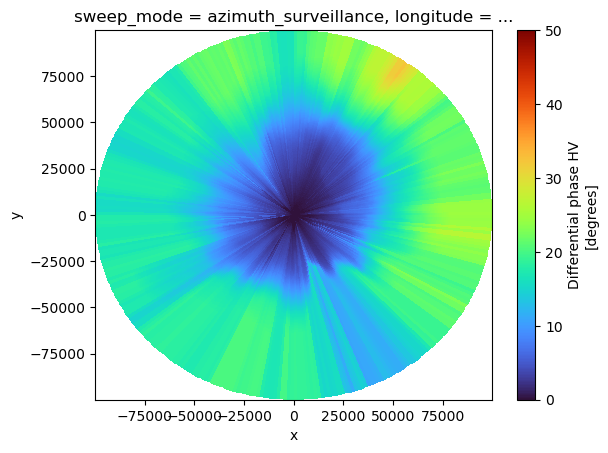

In [34]:
phical.where(swp_msk.PHIDP).plot(x="x", y="y", vmin=0, vmax=50, cmap="turbo")

### Apply attenuation correction 


In [35]:
print(alphax)

0.28


In [36]:
zhraw = swp.DBZH.copy()
zdrraw = swp.ZDR.copy()

In [37]:
with xr.set_options(keep_attrs=True):
    zhcorr = zhraw + alphax * (phical)
    zdiff = zhcorr - zhraw
    zdrcorr = zdrraw + betax * (phical)
    zdrdiff = zdrcorr - zdrraw

Text(0.5, 1.0, 'Corrected $Z_{DR}$')

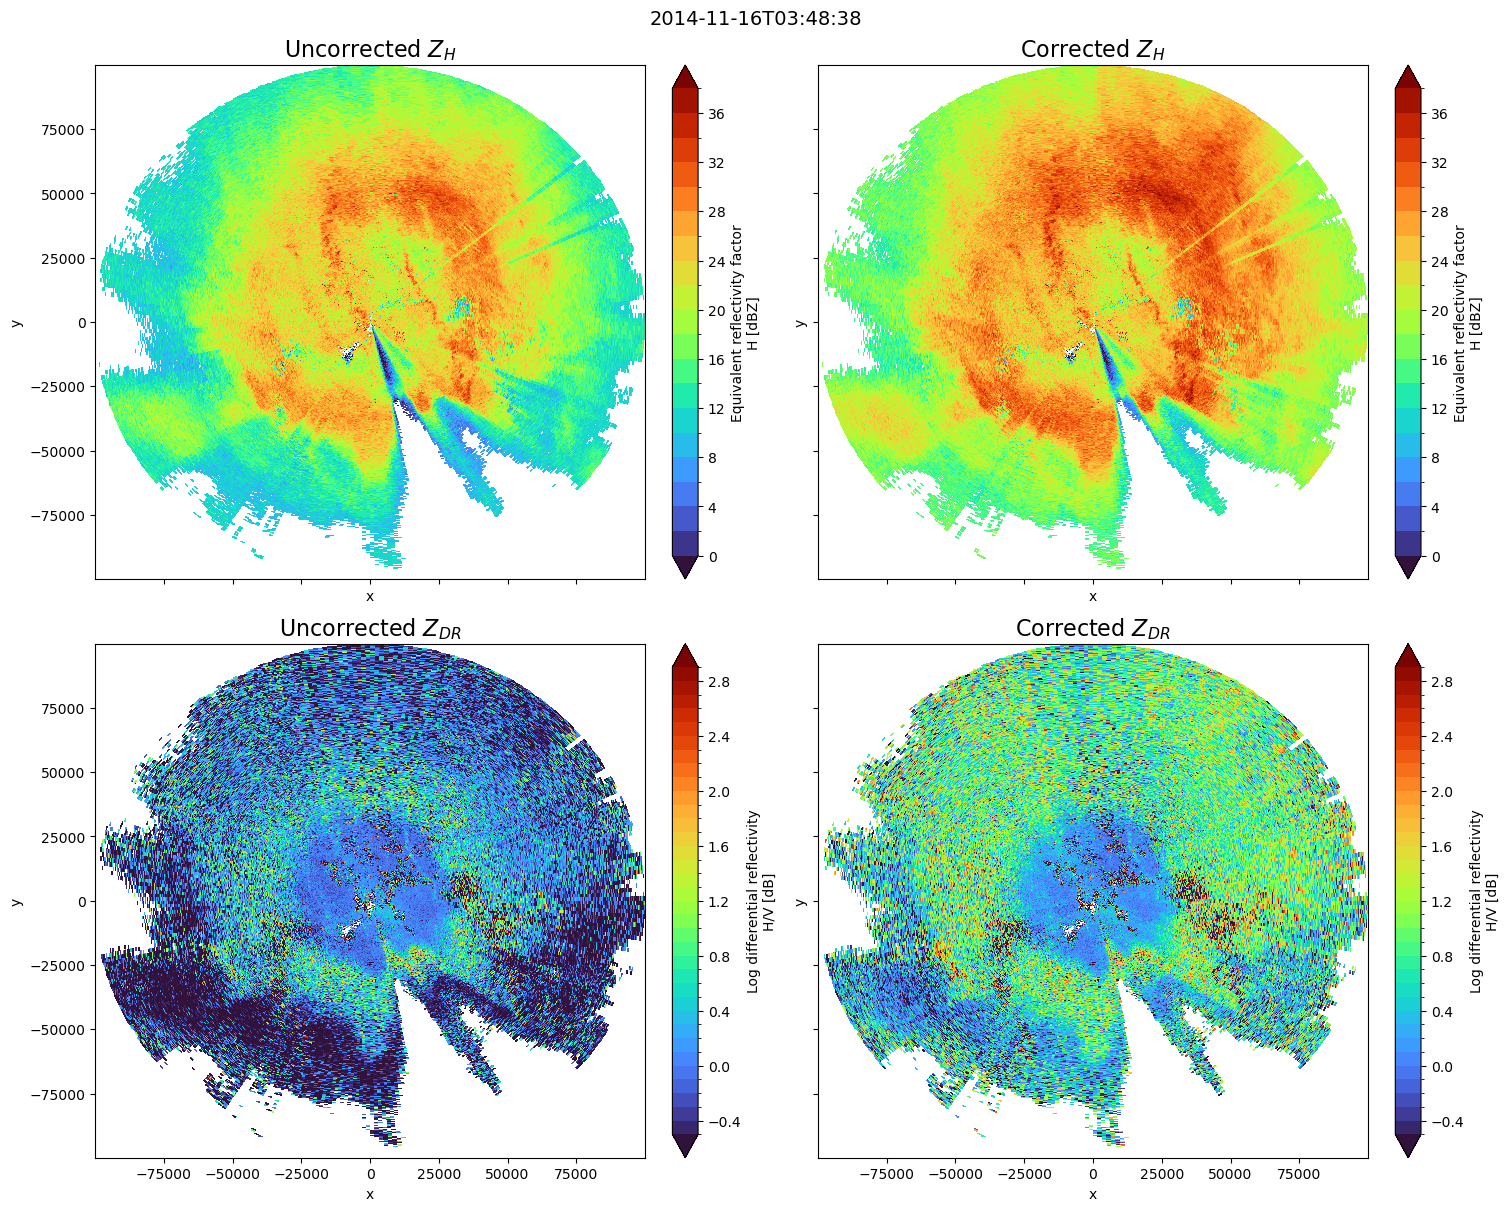

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(15, 12),
    sharex=True,
    sharey=True,
    squeeze=True,
    constrained_layout=True,
)

scantime = zhraw.time.values.astype("<M8[s]")
t = fig.suptitle(scantime, fontsize=14)
t.set_y(1.05)

zhraw.plot(x="x", y="y", ax=ax1, cmap="turbo", levels=np.arange(0, 40, 2))
ax1.set_title(r"Uncorrected $Z_{H}$", fontsize=16)
zhcorr.plot(x="x", y="y", ax=ax2, cmap="turbo", levels=np.arange(0, 40, 2))
ax2.set_title(r"Corrected $Z_{H}$", fontsize=16)

zdrraw.plot(x="x", y="y", ax=ax3, cmap="turbo", levels=np.arange(-0.5, 3, 0.1))
ax3.set_title(r"Uncorrected $Z_{DR}$", fontsize=16)
zdrcorr.plot(x="x", y="y", ax=ax4, cmap="turbo", levels=np.arange(-0.5, 3, 0.1))
ax4.set_title(r"Corrected $Z_{DR}$", fontsize=16)

## $K_{DP}$ from $A_H$ vs. $K_{DP}$ from $\phi_{DP}$ 

- $K_{DP} = \frac{A_H}{\alpha}$ 
- $K_{DP} = \frac{1}{2}\frac{\mathrm{d}\phi_{DP}}{\mathrm{d}r}$

What are the benefits of $K_{DP}(A_H)$? 

- no noise artefacts
- no $\delta$
- no negative $K_{DP}$
- no spatial degradation

In [40]:
def kdp_from_phidp(da, winlen, min_periods=2):
    """Derive KDP from PHIDP (based on convolution filter).

    Parameter
    ---------
    da : xarray.DataArray
        array with differential phase data
    winlen : int
        size of window in range dimension

    Keyword Arguments
    -----------------
    min_periods : int
        minimum number of valid bins

    Return
    ------
    kdp : xarray.DataArray
        DataArray with specific differential phase values
    """
    dr = da.range.diff("range").median("range").values / 1000.0
    print("range res [km]:", dr)
    print("processing window [km]:", dr * winlen)
    return xr.apply_ufunc(
        wrl.dp.kdp_from_phidp,
        da,
        input_core_dims=[["range"]],
        output_core_dims=[["range"]],
        dask="parallelized",
        kwargs=dict(winlen=winlen, dr=dr, min_periods=min_periods),
        dask_gufunc_kwargs=dict(allow_rechunk=True),
    )


def kdp_phidp_vulpiani(da, winlen, min_periods=2):
    """Derive KDP from PHIDP (based on Vulpiani).

    ParameterRHOHV_NC
    ---------
    da : xarray.DataArray
        array with differential phase data
    winlen : int
        size of window in range dimension

    Keyword Arguments
    -----------------
    min_periods : int
        minimum number of valid bins

    Return
    ------
    kdp : xarray.DataArray
        DataArray with specific differential phase values
    """
    dr = da.range.diff("range").median("range").values / 1000.0
    print("range res [km]:", dr)
    print("processing window [km]:", dr * winlen)
    return xr.apply_ufunc(
        wrl.dp.process_raw_phidp_vulpiani,
        da,
        input_core_dims=[["range"]],
        output_core_dims=[["range"], ["range"]],
        dask="parallelized",
        kwargs=dict(winlen=winlen, dr=dr, min_periods=min_periods),
        dask_gufunc_kwargs=dict(allow_rechunk=True),
    )

In [41]:
%%time
kdp1 = kdp_from_phidp(swp_msk.PHIDP, winlen=31, min_periods=11)
kdp1.attrs = xd.model.sweep_vars_mapping["KDP"]

kdp2 = kdp_phidp_vulpiani(swp.PHIDP, winlen=71, min_periods=21)[1]
kdp2.attrs = xd.model.sweep_vars_mapping["KDP"]

kdp3 = xr.zeros_like(kdp1)
kdp3.attrs = xd.model.sweep_vars_mapping["KDP"]
kdp3.data = ah / alphax

range res [km]: 0.1
processing window [km]: 3.1
range res [km]: 0.1
processing window [km]: 7.1000000000000005
CPU times: user 383 ms, sys: 84.9 ms, total: 468 ms
Wall time: 475 ms


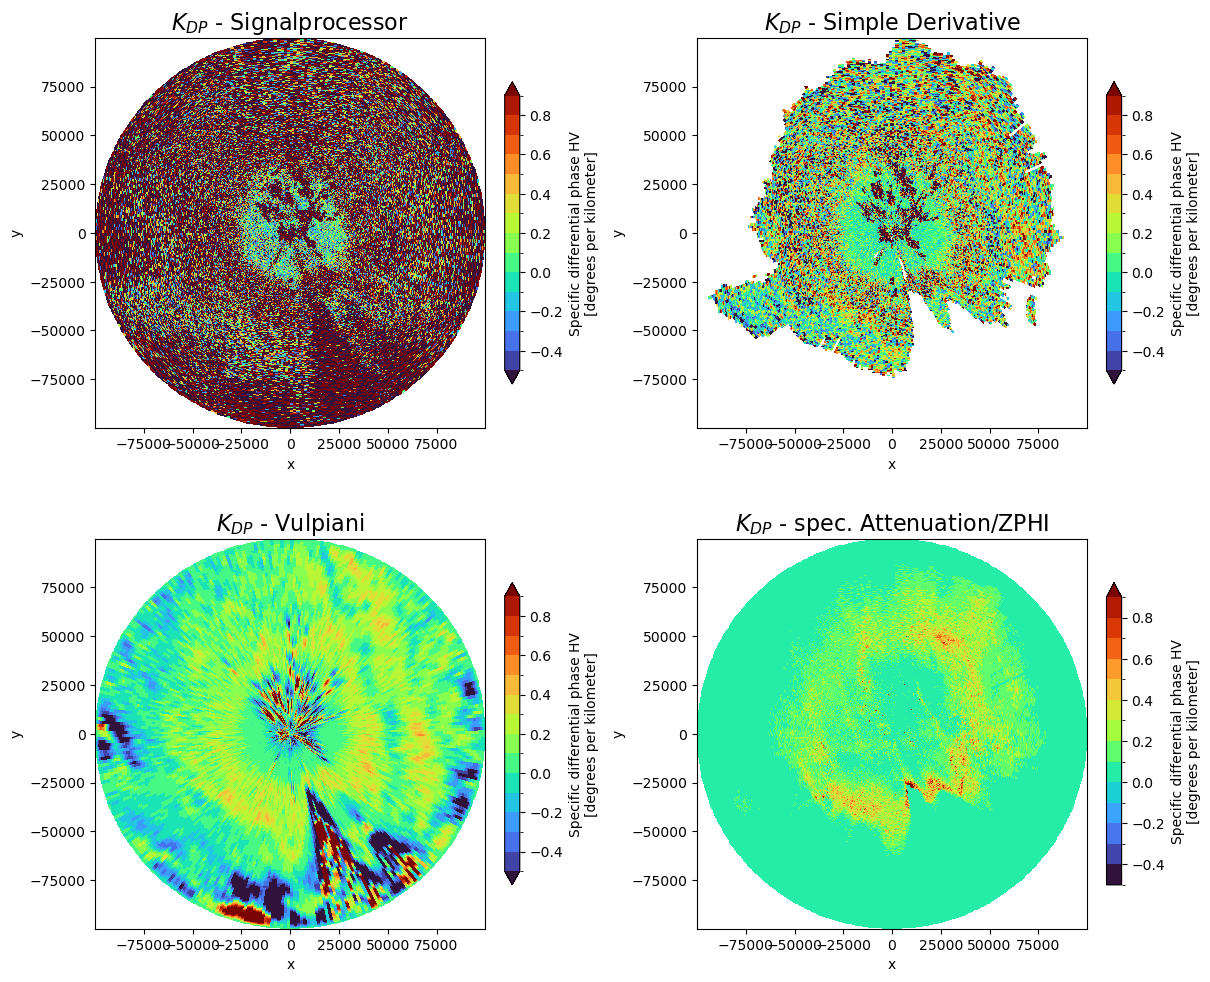

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 10), constrained_layout=True
)

swp.KDP.plot(
    x="x",
    y="y",
    ax=ax1,
    cmap="turbo",
    levels=np.arange(-0.5, 1, 0.1),
    cbar_kwargs=dict(shrink=0.64),
)
ax1.set_title(r"$K_{DP}$ - Signalprocessor", fontsize=16)
ax1.set_aspect("equal")
kdp1.plot(
    x="x",
    y="y",
    ax=ax2,
    cmap="turbo",
    levels=np.arange(-0.5, 1, 0.1),
    cbar_kwargs=dict(shrink=0.64),
)
ax2.set_title(r"$K_{DP}$ - Simple Derivative", fontsize=16)
ax2.set_aspect("equal")
kdp2.plot(
    x="x",
    y="y",
    ax=ax3,
    cmap="turbo",
    levels=np.arange(-0.5, 1, 0.1),
    cbar_kwargs=dict(shrink=0.64),
)
ax3.set_title(r"$K_{DP}$ - Vulpiani", fontsize=16)
ax3.set_aspect("equal")
kdp3.plot(
    x="x",
    y="y",
    ax=ax4,
    cmap="turbo",
    levels=np.arange(-0.5, 1, 0.1),
    cbar_kwargs=dict(shrink=0.64),
)
ax4.set_title(r"$K_{DP}$ - spec. Attenuation/ZPHI", fontsize=16)
ax4.set_aspect("equal")

---

## Summary
We've just learned how to derive System Phase Offset and Specific Attenuation AH using the ZPHI-Method. Different KDP derivation methods have been compared.


## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org/)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)
- Testud, J., Le Bouar, E., Obligis, E., & Ali-Mehenni, M. (2000). The Rain Profiling Algorithm Applied to Polarimetric Weather Radar, Journal of Atmospheric and Oceanic Technology, 17(3), 332-356. Retrieved Nov 24, 2021, from https://journals.ametsoc.org/view/journals/atot/17/3/1520-0426_2000_017_0332_trpaat_2_0_co_2.xml
- Diederich, M., Ryzhkov, A., Simmer, C., Zhang, P., & Trömel, S. (2015). Use of Specific Attenuation for Rainfall Measurement at X-Band Radar Wavelengths.: Part I: Radar Calibration and Partial Beam Blockage Estimation. Journal of Hydrometeorology, 16(2), 487–502. http://www.jstor.org/stable/24914953

### ZPHI-Method

see Testud et.al. (chapter 4. p. 339ff.), Diederich et.al. (chapter 3. p. 492 ff).

There is a equational difference in the two papers, which can be solved like this:

$\begin{equation}
f\Delta\phi_{DP} = 10^{0.1 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}} - 1
\tag{1}
\end{equation}$

$\begin{equation}
C(b, PIA) = \exp[{0.23 \cdot b \cdot (PIA)}] - 1
\tag{2}
\end{equation}$

with 

$\begin{equation}
PIA = \alpha \cdot \Delta\phi_{DP}
\tag{3}
\end{equation}$

$\begin{equation}
C(b, PIA) = \exp[{0.23 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}}] - 1
\tag{4}
\end{equation}$

Both expressions are used equivalently:

$\begin{equation}
10^{0.1 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}} - 1 = \exp[{0.23 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}}] - 1
\tag{5}
\end{equation}$


Using logarithmic identities:

$\begin{equation}
\ln {u^r} = r \cdot \ln {u}
\tag{6a}
\end{equation}$

$\begin{equation}
\exp {\ln x} = x
\tag{6b}
\end{equation}$

the left hand side can be further expressed as:

$\begin{equation}
\exp [\ln {10^{0.1 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}}}] - 1 = \exp[{0.23 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}}] - 1
\tag{7a}
\end{equation}$


$\begin{equation}
\exp[0.1 \cdot b \cdot \alpha \cdot \Delta\phi_{DP} \cdot \ln {10}] - 1 = \exp[{0.23 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}}] - 1
\tag{7b}
\end{equation}$

leading to equality

$\begin{equation}
\exp[0.23 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}] - 1 = \exp[{0.23 \cdot b \cdot \alpha \cdot \Delta\phi_{DP}}] - 1
\tag{7c}
\end{equation}$